# Part 6. Production Model Evaluation

## Importing libraries and setting global variables

In [1]:
# Import usual library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling library
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score

# Library to save the model
import pickle

## Importing datasets

In [2]:
#Select dataset to read
# Select 'train' to read train.csv
# Select 'test' to read test.csv

status = 'train'

if status == 'train':
    df = pd.read_csv('../datasets/train_cleaned.csv')
elif status == 'test':
    df = pd.read_csv('../datasets/test_cleaned.csv')
else:
    print(f"Select the correct dataset")

In [3]:
# View head
df.head(5)

,ms_zoning,lot_frontage,street,lot_shape,lot_contour,utilities,lot_config,lot_slope,neighborhood,condition_1,...,sale_price,has_2nd_floor_sf,total_sf,has_basement_sf,total_bath,has_open_porch,has_fireplace,has_wood_deck,log_sale_price,log_lot_area
0,Res,80.0,1.0,1.0,1.0,AllPub,Corner,1.0,SawyerW,N,...,159000,0,2436.0,1,1.5,1,0,0,11.976659,9.170039
1,Res,90.0,1.0,0.0,1.0,AllPub,CulDSac,1.0,SawyerW,N,...,271900,0,4354.0,1,2.0,1,1,1,12.513190,9.594514
2,Res,60.0,1.0,0.0,1.0,NoSeWa,CulDSac,1.0,Timber,N,...,137500,0,2163.0,1,1.5,1,1,0,11.831379,9.573246
3,Res,48.0,1.0,1.0,1.0,AllPub,Inside,1.0,NridgHt,N,...,248500,0,2907.0,1,2.0,1,1,1,12.423198,8.775240
4,Res,61.0,1.0,0.0,1.0,AllPub,Inside,1.0,Gilbert,R,...,167000,1,1758.0,1,2.5,0,0,0,12.025749,9.183380


# Run model to check numerical model

## Explanation of features
__Numerical Features:__ <br>
__*Overall Group*__
1. Overall Quality
    - Overall quality of the house scaling from 1-10
2. Overall Condition
    - Overall condition of the house scaling from 1-10

__*Area Group*__
1. Total Square Footage
    - Total square footage of the house
2. Lot Frontage Area
    - Total square footage of frontage of the lot
3. Natural Log of Lot Area
    - Natural log of square footage of lot area
4. Lot Shape
    - Shape of the house lot (Regular/Irregular)
5. Lot Contour
    - Leveling of the house lot (Level/Other)
6. Lot Slope
    - Slope of the house lot (Gentle/Other)

__*Spaces*__
1. Total Number of Rooms
2. Total Number of Bedrooms
3. Total Number of Bathrooms
4. Total Number of Kitchen
5. Number of Garage Capacity
6. Masonry Area

__*Functionality*__
1. Has a Fireplace
2. Has a Wooden Deck
3. Has an Open Porch
4. Has Central Air system
5. Has a Basement
6. Has a 2nd Floor
7. Functionality
    - How good the house functions

__*Other*__
1. Year Built
    - Year the house was built
2. Months Sold
    - Month the house was sold
3. Year Sold
    - Year the house was sold
4. Street
    - Street the house was located on
    
__Categorical Features:__ <br>
__*Quality (scaling from Excellent/Good/Average/Fair/Poor)*__
1. External Quality
2. Basement Quality
3. Heating Quality
4. Kitchen Quality
5. Fireplace Quality
6. Garage Quality

#### Linear Regression (with selected features)

In [15]:
# Select all quality related categorical columns
cat_cols = ['external_quality','basement_quality','heating_quality','kitchen_quality','fireplace_quality',
           'garage_quality']

In [16]:
# Selecting all numerical columns
num_cols = list(df.corr()['log_sale_price'].sort_values(ascending=False).index)

In [17]:
# Combine columns
cols = num_cols + cat_cols

In [18]:
# Selecting X and y for model training
X = df[cols].drop(columns=['sale_price','log_sale_price'])
y = df['sale_price']

In [19]:
# Get dummies for categorical columns
X = pd.get_dummies(columns=list(X.select_dtypes(include='object').columns), data = X, drop_first=True)

In [20]:
# Check columns
X.columns

Index(['overall_quality', 'total_sf', 'garage_cars', 'total_bath',
       'year_built', 'has_fireplace', 'total_rooms_above_ground',
       'has_open_porch', 'masonry_area', 'log_lot_area', 'lot_frontage',
       'has_wood_deck', 'central_air', 'has_basement_sf',
       'bedroom_above_ground', 'functional', 'street', 'has_2nd_floor_sf',
       'month_sold', 'year_sold', 'lot_contour', 'lot_slope',
       'overall_condition', 'kitchen_above_ground', 'lot_shape',
       'external_quality_Fa', 'external_quality_Gd', 'external_quality_TA',
       'basement_quality_E', 'basement_quality_G', 'basement_quality_O',
       'heating_quality_Fa', 'heating_quality_Gd', 'heating_quality_TA',
       'kitchen_quality_Gd', 'kitchen_quality_Ta', 'fireplace_quality_Fa',
       'fireplace_quality_Gd', 'fireplace_quality_None',
       'fireplace_quality_Po', 'fireplace_quality_TA', 'garage_quality_G',
       'garage_quality_O'],
      dtype='object')


====== Production Model ======

train r2: 0.9195
test_r2: 0.9281
mean cross val: [0.9057 0.9186 0.8972 0.9296 0.9099]
train rmse: 20051.38
test rmse: 20300.38


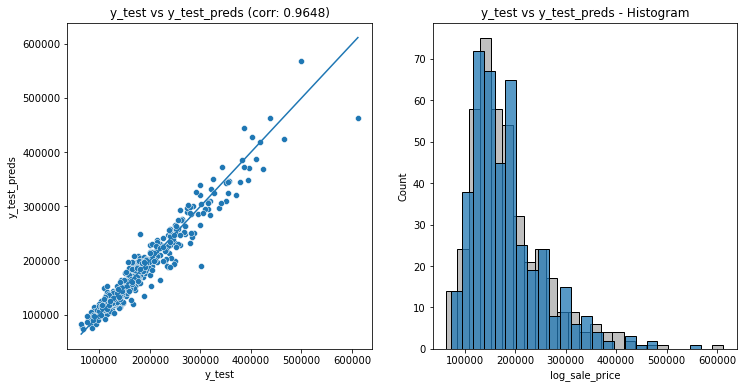

In [21]:
# train test split and instantiate
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2,random_state=42)
lr = LinearRegression()

# transform y to ln
y_train_log = np.log(y_train)
y_test_log = np.log(y_test)

# fit model to ln(y)
lr.fit(X_train,y_train_log)

# predict train and test
y_train_pred_log = lr.predict(X_train)
y_test_pred_log = lr.predict(X_test)

# exponential transform ln(y) back to y
y_train_preds = np.exp(y_train_pred_log)
y_test_preds = np.exp(y_test_pred_log)

# print model name
print()
print(" Production Model ".center(30, "="))

# train test R^2 scores
train_r2 = lr.score(X_train,y_train_log)
test_r2 = lr.score(X_test,y_test_log)

# cross validation score
mean_cross_val = cross_val_score(lr, X_train, y_train_log)

# metrics (comparing y_preds with y)
rmse_train = round(metrics.mean_squared_error(y_train,y_train_preds,squared=False),2)
rmse_test = round(metrics.mean_squared_error(y_test,y_test_preds,squared=False),2)

# print model scores
print()
print(f"train r2: {train_r2.round(4)}")
print(f"test_r2: {test_r2.round(4)}")
print(f"mean cross val: {mean_cross_val.round(4)}")
print(f"train rmse: {rmse_train}")
print(f"test rmse: {rmse_test}")

# create plots of predictions vs true values - to help visualize model performance
fig, axes = plt.subplots(1, 2, figsize=(12,6))

# correlation calculation
cor = np.corrcoef(y_test,y_test_preds)

# scatter plot (left) of y_test vs y_test_preds
plot1 = sns.scatterplot(ax=axes[0],x=y_test,y=y_test_preds)
sns.lineplot(ax=axes[0],x=y_test,y=y_test)
plot1.set_xlabel('y_test')
plot1.set_ylabel('y_test_preds')
plot1.set_title(f"y_test vs y_test_preds (corr: {cor[0][1].round(4)})")

# histogram (right) of y_test vs y_test_preds
plot2 = sns.histplot(ax=axes[1],x=y_test,color='grey',alpha=0.5)
plot2 = sns.histplot(ax=axes[1],x=y_test_preds)
plot2.set_title(f"y_test vs y_test_preds - Histogram")
plot2.set_xlabel('log_sale_price');

## Evaluation

Upon iterating many different models from selecting only numerical columns to select 10-12 categorical columns. This is our optimal production suitable model for the following reasons.

__1. Numerical Columns:__
- This model is a simplified version numerical columns
- Keeping all cleaned numerical featurs perform better than selecting only a few correlated features
- This is because fitting the model calculates the best coefficients to make use of all our features
- Note that is only works if the dataset has been cleaned to a certain degree

__2. Categorical Columns:__
- This model selects only generic categorical columns (i.e. quality related columns)
- This avoids overfitting in the future since they're columns that all houses should have
- These selected categorical columns has acceptable distribution of values
- Allowing us to train the model without overfitting

__3. Metrics:__
- Comparing the R^2 values of both the training and testing datasets shows slight difference
- Cross validation also shows extremely small differences in R2 for all 5 sets
- Overfitting is unlikely in this case
- The RMSE of the train data is very low and the RMSE of the test data is within acceptable range
- Meaning this model performs well while being unlikely to overfit in the future